In [1]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [208]:
import warnings
warnings.filterwarnings('ignore')
import gc

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))

In [4]:
df = pd.DataFrame()
for f in files:
    try:
        if df.empty:
            df = pd.read_csv(f)
        else:
            df = pd.concat([df,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


In [5]:
df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
df = df.set_index('Datetime')
df = df.drop(columns=['date','hour'])

In [10]:
#Question: Do we need to remove all pollutants with suffix '_24h'?
pollutant = set(df.type)
pollutant.remove('AQI')
pollutant = [p for p in pollutant if '24h' not in p]
df = df.loc[df['type'].isin(pollutant)]

In [11]:
#build a model for '万柳' first
subset = df.loc[:,['type','万柳']]
subset.sort_values(by = ['Datetime'])
subset = subset.pivot_table(values='万柳', index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

In [260]:
#filling missing hours
subset_augmented = subset.asfreq('h')

In [261]:
subset_augmented = subset_augmented.interpolate(method = 'linear')

In [262]:
#before April 2014, there is no extra data. Therefore we only use data after that time
subset_augmented = subset_augmented.dropna()

In [265]:
subset_augmented.rolling(24).mean()

,CO,NO2,O3,PM10,PM2.5,SO2
Datetime,,,,,,
2014-04-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-02 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-02 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-02 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-02 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2016-12-29 05:00:00,0.991667,43.541667,31.208333,47.708333,29.125000,9.750000
2016-12-29 06:00:00,0.937500,42.916667,31.875000,42.291667,24.333333,10.000000
2016-12-29 07:00:00,0.841667,42.000000,32.416667,37.395833,19.833333,10.208333


In [247]:
#create lag variables
res = subset_augmented
for lag in range(1,25):
    tmp = subset_augmented.shift(lag)
    tmp.columns=[f'{c}_lag_{lag}' for c in subset_augmented.columns]
    res = pd.concat([res,tmp],axis=1)

In [248]:
res["month"] = res.index.month

In [249]:
res["target"] = res["PM2.5"].shift(-1) #target column

In [250]:
subset_augmented =  res.dropna()

In [251]:
#NB: if we have a missing value on the original data, we need to exclude them
subset_augmented = pd.merge(subset_augmented, ~subset["PM2.5"].shift(-1).isna(), left_index=True, right_index=True,suffixes=['','_y'])
subset_augmented = subset_augmented[subset_augmented['PM2.5_y']==True]
subset_augmented = subset_augmented.drop(columns=['PM2.5_y'])

In [252]:
subset_augmented

,CO,NO2,O3,PM10,PM2.5,SO2,CO_lag_1,NO2_lag_1,O3_lag_1,PM10_lag_1,...,PM2.5_lag_23,SO2_lag_23,CO_lag_24,NO2_lag_24,O3_lag_24,PM10_lag_24,PM2.5_lag_24,SO2_lag_24,month,target
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-04-03 12:00:00,1.0,33.0,69.0,129.0,13.0,5.0,1.0,39.0,63.0,99.0,...,52.0,14.0,1.0,61.0,95.0,13.0,66.0,15.0,4,5.0
2014-04-03 13:00:00,1.0,25.0,78.0,89.0,5.0,2.0,1.0,33.0,69.0,129.0,...,65.0,16.0,1.0,58.0,109.0,66.0,52.0,14.0,4,13.0
2014-04-03 14:00:00,1.0,22.0,82.0,56.0,13.0,2.0,1.0,25.0,78.0,89.0,...,102.0,24.0,1.0,58.0,121.0,125.0,65.0,16.0,4,18.0
2014-04-03 15:00:00,1.0,20.0,82.0,67.5,18.0,2.0,1.0,22.0,82.0,56.0,...,108.0,30.0,1.0,64.0,125.0,188.0,102.0,24.0,4,7.0
2014-04-03 16:00:00,1.0,18.0,77.0,79.0,7.0,3.0,1.0,20.0,82.0,67.5,...,120.0,35.0,2.0,67.0,129.0,157.0,108.0,30.0,4,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-29 04:00:00,0.8,63.0,5.0,20.0,14.0,11.0,0.9,57.0,10.0,21.0,...,165.0,5.0,2.0,72.0,2.0,150.0,177.0,6.0,12,12.0
2016-12-29 05:00:00,1.0,59.0,8.0,19.0,12.0,10.0,0.8,63.0,5.0,20.0,...,128.0,5.0,2.0,68.0,2.0,149.0,165.0,5.0,12,13.0
2016-12-29 06:00:00,0.8,52.0,18.0,18.0,13.0,11.0,1.0,59.0,8.0,19.0,...,122.0,7.0,2.1,67.0,2.0,148.0,128.0,5.0,12,14.0


In [125]:
from sklearn.model_selection import TimeSeriesSplit

In [160]:
# fit a single model
def fit_model(model, X, y):
    local_model = clone(model)
    local_model.fit(X, y)
    return local_model

In [200]:
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [201]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor


In [185]:
!pip install lightgbm

In [202]:
import lightgbm as lgb

In [254]:
params = {'num_leaves': 555,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 222,
         }

In [255]:
# y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(subset_augmented.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = subset_augmented.columns[:-1]
mean_score = []

In [256]:
tscv = TimeSeriesSplit(5)

In [257]:
# model = RandomForestRegressor()
# i=1
# for train_index, test_index in tscv.split(subset_augmented):

#     x_train = subset_augmented.loc[subset_augmented.index[train_index],subset_augmented.columns!="target"]
#     y_train = subset_augmented.loc[subset_augmented.index[train_index],"target"]
#     x_test = subset_augmented.loc[subset_augmented.index[test_index],subset_augmented.columns!="target"]
#     y_test = subset_augmented.loc[subset_augmented.index[test_index],"target"]
    
#     fitted = fit_model(model, x_train, y_train)
# #     print(f"score is {fitted.score(x_train,y_train)}")
#     y_predicted = fitted.predict(x_test)
#     print(f"split {i}")
#     i+=1
#     print(f"MAE is {mean_absolute_error(y_test,y_predicted)}")
#     print(f"MPAE is {mean_absolute_percentage_error(y_test,y_predicted)}")
# #     y_train, y_test = y[train_index], y[test_index]

In [258]:
for fold_n, (train_index, valid_index) in enumerate(tscv.split(subset_augmented)):
    print(f'Fold: {fold_n+1}')
    X_train, X_valid = subset_augmented.iloc[train_index].loc[:,subset_augmented.columns!="target"],subset_augmented.iloc[valid_index].loc[:,subset_augmented.columns!="target"]
    y_train, y_valid = subset_augmented.iloc[train_index].loc[:,"target"], subset_augmented.iloc[valid_index].loc[:,"target"]
    
    dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature = ['month'])
    dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature = ['month'])
    
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print(f'mean rmse score over folds is {np.mean(mean_score)}')

Fold: 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 37.0548	valid_1's rmse: 69.7944
[200]	training's rmse: 27.4581	valid_1's rmse: 55.7342
[300]	training's rmse: 22.2074	valid_1's rmse: 47.7581
[400]	training's rmse: 19.3636	valid_1's rmse: 43.021
[500]	training's rmse: 17.681	valid_1's rmse: 40.0025
[600]	training's rmse: 16.6583	valid_1's rmse: 38.0513
[700]	training's rmse: 15.9133	valid_1's rmse: 36.756
[800]	training's rmse: 15.3848	valid_1's rmse: 35.8168
[900]	training's rmse: 14.9655	valid_1's rmse: 35.1534
[1000]	training's rmse: 14.6102	valid_1's rmse: 34.7102
[1100]	training's rmse: 14.2903	valid_1's rmse: 34.3225
[1200]	training's rmse: 13.9996	valid_1's rmse: 34.0322
[1300]	training's rmse: 13.7341	valid_1's rmse: 33.8616
[1400]	training's rmse: 13.4873	valid_1's rmse: 33.7098
[1500]	training's rmse: 13.2546	valid_1's rmse: 33.6408
[1600]	training's rmse: 13.0327	valid_1's rmse: 33.5832
Early stopping, best iteration is:
[1586]	train

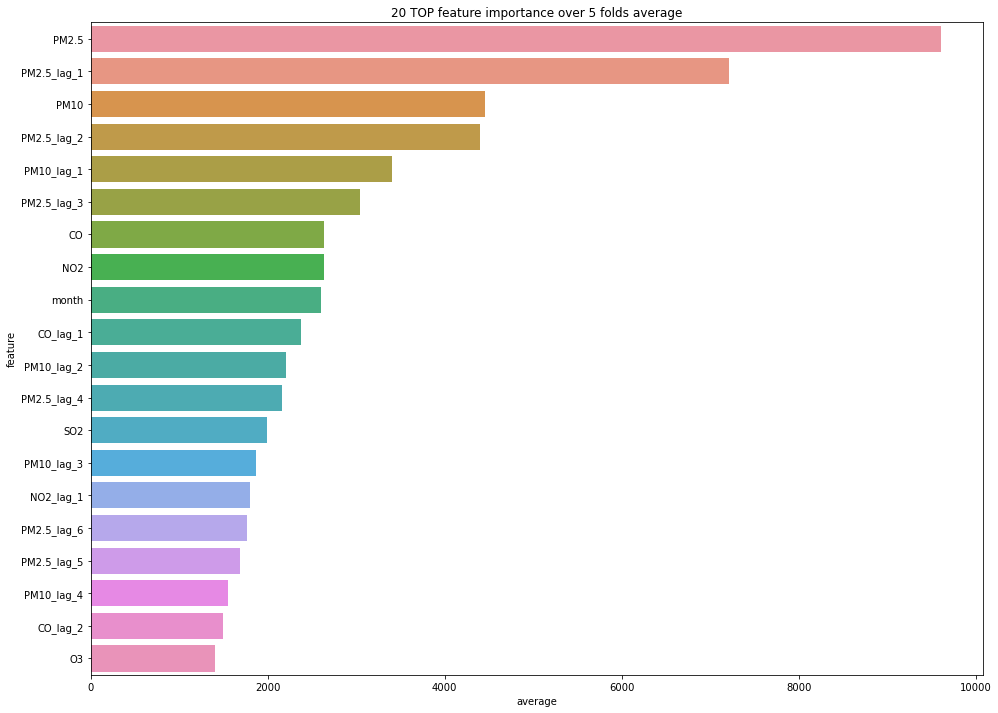

In [259]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(tscv.n_splits)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(tscv.n_splits));

In [162]:
import sklearn
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [144]:
for train_index, test_index in tscv.split(subset_augmented):
    print(train_index)

[   0    1    2 ... 3854 3855 3856]
[   0    1    2 ... 7710 7711 7712]
[    0     1     2 ... 11566 11567 11568]
[    0     1     2 ... 15422 15423 15424]
[    0     1     2 ... 19278 19279 19280]


In [145]:
tscv.split(subset_augmented)

<generator object TimeSeriesSplit.split at 0x000001AB02D7F1C8>

In [146]:
def build_model(_alpha, _l1_ratio):
    estimator = ElasticNet(
        alpha=_alpha,
        l1_ratio=_l1_ratio,
        fit_intercept=True,
        normalize=False,
        precompute=False,
        max_iter=16,
        copy_X=True,
        tol=0.1,
        warm_start=False,
        positive=False,
        random_state=None,
        selection='random'
    )

    return estimator

In [149]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [151]:
x_train=subset_augmented.loc[:,subset_augmented.columns!="target"]
y_train=subset_augmented.loc[:,"target"]

In [153]:
model = build_model(_alpha=1.0, _l1_ratio=0.3)
tscv = TimeSeriesSplit(n_splits=5)
rmse = np.sqrt(-cross_val_score(model, x_train, y_train, cv=tscv, scoring='neg_mean_squared_error'))
R2 = cross_val_score(model, x_train, y_train, cv=tscv, scoring='r2')

print(f"RMSE: {rmse.mean()} (+/- {rmse.std()}")
print(f"\nR2: {R2.mean()} (+/- {R2.std()}")

RMSE: nan (+/- nan

R2: nan (+/- nan


In [154]:
x_train

,CO,NO2,O3,PM10,PM2.5,SO2,CO_lag_1,NO2_lag_1,O3_lag_1,PM10_lag_1,...,O3_lag_23,PM10_lag_23,PM2.5_lag_23,SO2_lag_23,CO_lag_24,NO2_lag_24,O3_lag_24,PM10_lag_24,PM2.5_lag_24,SO2_lag_24
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-04-03 12:00:00,1.0,33.0,69.0,129.0,13.0,5.0,1.0,39.0,63.0,99.0,...,109.0,66.0,52.0,14.0,1.0,61.0,95.0,13.0,66.0,15.0
2014-04-03 13:00:00,1.0,25.0,78.0,89.0,5.0,2.0,1.0,33.0,69.0,129.0,...,121.0,125.0,65.0,16.0,1.0,58.0,109.0,66.0,52.0,14.0
2014-04-03 14:00:00,1.0,22.0,82.0,56.0,13.0,2.0,1.0,25.0,78.0,89.0,...,125.0,188.0,102.0,24.0,1.0,58.0,121.0,125.0,65.0,16.0
2014-04-03 15:00:00,1.0,20.0,82.0,67.5,18.0,2.0,1.0,22.0,82.0,56.0,...,129.0,157.0,108.0,30.0,1.0,64.0,125.0,188.0,102.0,24.0
2014-04-03 16:00:00,1.0,18.0,77.0,79.0,7.0,3.0,1.0,20.0,82.0,67.5,...,117.0,263.0,120.0,35.0,2.0,67.0,129.0,157.0,108.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-29 04:00:00,0.8,63.0,5.0,20.0,14.0,11.0,0.9,57.0,10.0,21.0,...,2.0,149.0,165.0,5.0,2.0,72.0,2.0,150.0,177.0,6.0
2016-12-29 05:00:00,1.0,59.0,8.0,19.0,12.0,10.0,0.8,63.0,5.0,20.0,...,2.0,148.0,128.0,5.0,2.0,68.0,2.0,149.0,165.0,5.0
2016-12-29 06:00:00,0.8,52.0,18.0,18.0,13.0,11.0,1.0,59.0,8.0,19.0,...,2.0,147.5,122.0,7.0,2.1,67.0,2.0,148.0,128.0,5.0


In [155]:
y_train

Datetime
2014-04-03 12:00:00     5.0
2014-04-03 13:00:00    13.0
2014-04-03 14:00:00    18.0
2014-04-03 15:00:00     7.0
2014-04-03 16:00:00     3.0
                       ... 
2016-12-29 04:00:00    12.0
2016-12-29 05:00:00    13.0
2016-12-29 06:00:00    14.0
2016-12-29 07:00:00    14.0
2016-12-29 08:00:00    19.0
Name: target, Length: 23137, dtype: float64